# Sparkify 项目 
**项目目标**：建立一个模型来预测客户的流失情况

**项目流程**：
* 加载清洗数据
* 探索性数据分析
* 特征工程
* 建模
* 模型选择并预测

## 1 导入库

In [2]:
# 导入所需要的库
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import avg, col, concat, asc,desc, explode, lit , min , max ,split
from pyspark.sql.functions import sum as Fsum
from pyspark.sql import Window

from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC,GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import Normalizer, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## 2 加载和清洗数据 

In [3]:
# 创建一个SpakSession，默认为local（.master没有设定）
spark = SparkSession.builder.getOrCreate()
# 我提前将原文件在系统中压缩成了bz2格式，再读取
df = spark.read.json('mini_sparkify_event_data.json.bz2')
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [4]:
# 查看数据的类型情况
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
# 去除可能存在空值的列的空值
df_1 = df.dropna(how = 'any',subset = ['userId','sessionId'])
# 查看重要的字段‘userId’，去除重复值
df_1.select(['userId','sessionId']).dropDuplicates().sort('userId').show(10)

+------+---------+
|userId|sessionId|
+------+---------+
|      |     1359|
|      |      565|
|      |      814|
|      |     1053|
|      |      268|
|      |     1305|
|      |     1446|
|      |     1592|
|      |      164|
|      |     1183|
+------+---------+
only showing top 10 rows



* 查看'userId'发现存在空字符串的用户，需要去除

In [6]:
# 去除空字符串用户
df_2 = df_1.where(df.userId !='')
# 查看数据集前后数量变化
print('去除空字符用户前数据集的数量：', df_1.count())
print('去除空字符串用户后数据集的数量：', df_2.count())

去除空字符用户前数据集的数量： 286500
去除空字符串用户后数据集的数量： 278154


## 3 探索性数据分析
当你使用完整数据集时，通过加载小数据集，在 Spark 中完成基础操作来实现探索性数据分析。在这个 Workspace 中，我们已经提供给你一个你可以探索的小数据集。


### 3.1 创建新列

In [7]:
# 首先查看数据‘page’列,需要设置show()方法的truncate参数以显示完整
df_2.select('page').dropDuplicates().show(truncate=30)

+-------------------------+
|                     page|
+-------------------------+
|                   Cancel|
|         Submit Downgrade|
|              Thumbs Down|
|                     Home|
|                Downgrade|
|              Roll Advert|
|                   Logout|
|            Save Settings|
|Cancellation Confirmation|
|                    About|
|                 Settings|
|          Add to Playlist|
|               Add Friend|
|                 NextSong|
|                Thumbs Up|
|                     Help|
|                  Upgrade|
|                    Error|
|           Submit Upgrade|
+-------------------------+



* 观察page列表可以看到一些有意思的行为，比如Downgrade，Thumbs Up点赞行为等，我们这里将Cancellation Confirmation来定定义客户流失event_churn

#### 3.1.1 创建用户流失列

In [8]:
# 创建新的一列event_churn
create_event_churn = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df_3 = df_2.withColumn('event_churn', create_event_churn('page'))

# 使用窗口函数按userId分组，对数据进行去重,只要有过Cancellation Confirmation行为的用户就标记为1
window_df_3 = Window.partitionBy('userId')
df_clean = df_3.withColumn('churn', max('event_churn').over(window_df_3))

In [9]:
# 查看用户标记情况
df_clean.select(['userId','churn']).dropDuplicates().show(10)

+------+-----+
|userId|churn|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
|     7|    0|
|    15|    0|
|    54|    1|
|   155|    0|
|100014|    1|
+------+-----+
only showing top 10 rows



#### 3.1.2 转换时间

In [10]:
df_clean.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', event_churn=0, churn=0)

* 从数据中我们可以看出属性‘ts’以及‘registration’为时间属性，我们需要将他们转换成timestamp的形式

In [11]:
# 使用datetime.datetime.fromtimestamp().strftime("%Y-%m-%d %H:%M:%s")，因为数据时间戳为13位,最后三位为0,要转换成10位

ts_transform = udf(lambda x:datetime.datetime.fromtimestamp(x/1000).strftime("%Y-%m-%d %H:%M:%s"))
df_clean = df_clean.withColumn('time',ts_transform('ts'))
df_clean = df_clean.withColumn('registration_time',ts_transform('registration'))


In [12]:
# 查看时间相关列修改情况
df_clean.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', event_churn=0, churn=0, time='2018-10-08 12:58:1539003534', registration_time='2018-09-27 02:45:1538016340')

* 可以看到数据中有修改好形式的时间相关属性了
* 我们可以把数据转为pandas dataframe 形式查看一下

In [13]:
pd = df_clean.toPandas()
pd.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,sessionId,song,status,ts,userAgent,userId,event_churn,churn,time,registration_time
0,Sleeping With Sirens,Logged In,Darianna,F,0,Carpenter,202.97098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,31,Captain Tyin Knots VS Mr Walkway (No Way),200,1539003534000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,0,2018-10-08 12:58:1539003534,2018-09-27 02:45:1538016340
1,Francesca Battistelli,Logged In,Darianna,F,1,Carpenter,196.54485,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,31,Beautiful_ Beautiful (Album),200,1539003736000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,0,2018-10-08 13:02:1539003736,2018-09-27 02:45:1538016340
2,Brutha,Logged In,Darianna,F,2,Carpenter,263.13098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,31,She's Gone,200,1539003932000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,0,2018-10-08 13:05:1539003932,2018-09-27 02:45:1538016340
3,None,Logged In,Darianna,F,3,Carpenter,NaN,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,31,None,307,1539003933000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,0,2018-10-08 13:05:1539003933,2018-09-27 02:45:1538016340
4,Josh Ritter,Logged In,Darianna,F,4,Carpenter,316.23791,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,31,Folk Bloodbath,200,1539004195000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,0,2018-10-08 13:09:1539004195,2018-09-27 02:45:1538016340


In [14]:
# 查看数据统计情况
pd.describe()

,itemInSession,length,registration,sessionId,status,ts,event_churn,churn
count,278154.000000,228108.000000,2.781540e+05,278154.000000,278154.000000,2.781540e+05,278154.000000,278154.000000
mean,114.899182,249.117182,1.535359e+12,1042.561624,209.103216,1.540959e+12,0.000187,0.161292
std,129.851729,99.235179,3.291322e+09,726.501036,30.151389,1.506829e+09,0.013672,0.367801
min,0.000000,0.783220,1.521381e+12,1.000000,200.000000,1.538352e+12,0.000000,0.000000
25%,27.000000,199.888530,1.533522e+12,338.000000,200.000000,1.539699e+12,0.000000,0.000000
50%,70.000000,234.500770,1.536664e+12,1017.000000,200.000000,1.540934e+12,0.000000,0.000000
75%,157.000000,277.158730,1.537672e+12,1675.000000,200.000000,1.542268e+12,0.000000,0.000000
max,1321.000000,3024.665670,1.543247e+12,2474.000000,404.000000,1.543799e+12,1.000000,1.000000


#### 3.2 可视化探索
你定义好客户流失后，就可以执行一些探索性数据分析，观察留存用户和流失用户的行为。你可以首先把这两类用户的数据聚合到一起，观察固定时间内某个特定动作出现的次数或者播放音乐的数量。

##### 3.2.1 Churn on Genders 可视化

In [15]:
df_gender_churn = df_clean.dropDuplicates(['userId','gender']).groupBy(['churn','gender']).count().sort('churn').toPandas()

* 从图中可看出，男用户流失比女用户略多一点

#### 3.2.2 Churn on Level 可视化

In [16]:
#df_type_churn = df_clean.dropDuplicates(['userId','level']).where('churn==1').groupby('level').count().toPandas()
#最初我使用churn来做的筛选，是不对的，因为churn标记的用户里，可能存在同一个用户有两个level的情况，
#并不能反映用户在流失时当下的level情况，所以应该选择page=="Cancellation Confirmation"来作为筛选的条件
df_type_churn = df_clean.where('page=="Cancellation Confirmation"').groupby('level').count().toPandas()

Text(0.5,1,'Churn happens more when users use to pay')

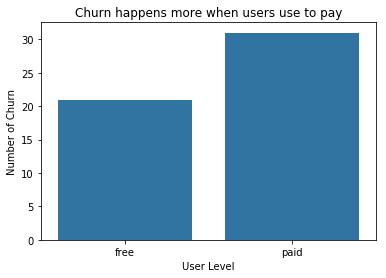

In [17]:
sns.barplot(data = df_type_churn, x = 'level', y = 'count', color = sns.color_palette()[0])
plt.xlabel("User Level")
plt.ylabel("Number of Churn")
plt.title('Churn happens more when users use to pay')

* 从图形中可以观察得出曾使用过付费的用户反而比免费使用的用户流失的多，说明应用所提供的服务可能很不好。

#### 3.2.3 Churn on Ratio of Thumbs Up/Down 可视化

In [18]:
# 筛选出好评和差评的数据
df_thumbs = df_clean.where('page == "Thumbs Up" OR page =="Thumbs Down"').groupby(['userId','churn','page']).count().sort('userId').toPandas()

In [19]:
# 对数据格式进行一定的调整，并计算出点赞和差评的平均值
df_thumbs =df_thumbs.groupby(['churn','page'])['count'].mean().reset_index()
df_thumbs =df_thumbs.pivot_table(index = 'churn', values = 'count', columns = 'page')

In [20]:
df_thumbs = df_thumbs.reset_index()

In [21]:
# 创建一个新列，计算点赞和差评之间的比值
df_thumbs['ratio_thumbs'] = df_thumbs['Thumbs Up']/df_thumbs['Thumbs Down']
df_thumbs.head()

page,churn,Thumbs Down,Thumbs Up,ratio_thumbs
0,0,13.225806,62.894118,4.755409
1,1,10.333333,37.180000,3.598065


Text(0.5,1,'Less churn  when Ratio of Thumbs Up/Down is high')

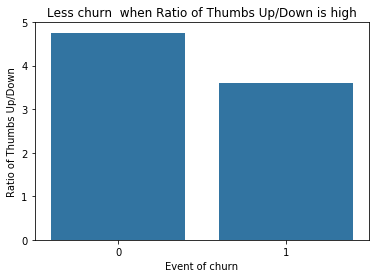

In [22]:
sns.barplot(data = df_thumbs,x = 'churn', y = 'ratio_thumbs', color = sns.color_palette()[0] )
plt.xlabel('Event of churn')
plt.ylabel('Ratio of Thumbs Up/Down')
plt.title('Less churn  when Ratio of Thumbs Up/Down is high')

* 从图中观察发现，点赞与差评之间的比值与用户流失与否有着一定的关系，比值越高的用户相对来说不容易流失。

#### 3.2.4 Churn on Time-interval 可视化

In [23]:
# 添加新的一列，计算用户使用时间区间
df_time = df_clean.select('userId','registration','ts','churn')\
    .withColumn('time_interval',(df_clean.ts-df_clean.registration)).toPandas()

In [24]:
df_time = df_time.groupby(['userId','churn'])['time_interval'].max().reset_index()
# 对时间区间一列做转换，将其换算成日为单位
df_time.time_interval = df_time.time_interval.apply(lambda x:round(x/1000/3600/24))

Text(0.5,1,'Users who churned use app for a shorter time')

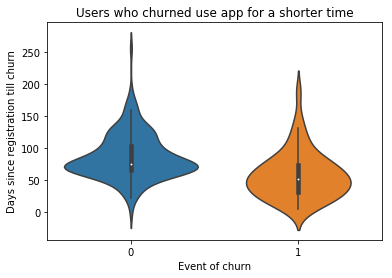

In [25]:
sns.violinplot(data = df_time,x = 'churn', y = 'time_interval')
plt.xlabel('Event of churn')
plt.ylabel('Days since registration till churn')
plt.title('Users who churned use app for a shorter time')

* 从图形中可以看出，流失的用户相对于没有流失的用户总体使用应用服务的时间要少一些

## 4 特征工程
熟悉了数据之后，就可以构建你认为会对训练模型帮助最大的特征。要处理完整数据集，你可以按照下述步骤：
- 写一个脚本来从小数据集中提取你需要的特征
- 确保你的脚本可以拓展到大数据集上，使用之前教过的最佳实践原则
- 在完整数据集上运行你的脚本，按运行情况调试代码

如果是在教室的 workspace，你可以直接用里面提供的小数据集来提取特征。确保当你开始使用 Spark 集群的时候，把上述的成果迁移到大数据集上。

### 4.1 创建特征

In [26]:
# 首先选择创建目标标签
label = df_clean.select('userId','churn')\
    .withColumnRenamed('churn','label')\
    .dropDuplicates()

In [27]:
label.show(10)

+------+-----+
|userId|label|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
|     7|    0|
|    15|    0|
|    54|    1|
|   155|    0|
|100014|    1|
+------+-----+
only showing top 10 rows



In [28]:
# 创建用户总共听过的歌曲数量特征
f_1 = df_clean.select('userId','song')\
    .groupby('userId')\
    .count()\
    .withColumnRenamed('count','total_songs')


In [29]:
f_1.describe().show()

+-------+------------------+-----------------+
|summary|            userId|      total_songs|
+-------+------------------+-----------------+
|  count|               225|              225|
|   mean|65391.013333333336|          1236.24|
| stddev|105396.47791907164|1329.531716432519|
|    min|                10|                6|
|    max|                99|             9632|
+-------+------------------+-----------------+



In [30]:
# # 创建用户性别特征，由于性别特征为字符串格式，需要做一个转换,使用方法StringIndexer
# index_gender = StringIndexer(inputCol='gender', outputCol='gender_index')
# df_clean = index_gender.fit(df_clean).transform(df)

In [31]:
# 创建性别特征
# f_2 = df_clean.select('userId','gender')\
#     .dropDuplicates()\
#     .replace(['M','F'],['0','1'],'gender')\
#     .select('userId',col('gender').cast('int'))

In [32]:
#df_clean.select('userId','gender_index').dropDuplicates().show()
#在这个操作中出现了一个问题，就是无法去重

In [33]:
# 尝试先去重，在做转换
df_gender = df_clean.dropDuplicates(['userId','gender'])
index_gender = StringIndexer(inputCol='gender', outputCol='gender_index')
df_gender = index_gender.fit(df_gender).transform(df_gender)

In [34]:
f_2 = df_gender.select('userId',col('gender_index').cast('int'))
#转换成功，发现StringIndexer方法应该是根据列表内变量顺序来进行编码的
f_2.show(10)

+------+------------+
|userId|gender_index|
+------+------------+
|    44|           1|
|    46|           1|
|    41|           1|
|    72|           1|
|300023|           1|
|    39|           1|
|100010|           1|
|    40|           1|
|    94|           1|
|    35|           1|
+------+------------+
only showing top 10 rows



In [35]:
f_2.describe().show()

+-------+------------------+-------------------+
|summary|            userId|       gender_index|
+-------+------------------+-------------------+
|  count|               225|                225|
|   mean|65391.013333333336| 0.4622222222222222|
| stddev|105396.47791907165|0.49968243883744773|
|    min|                10|                  0|
|    max|                99|                  1|
+-------+------------------+-------------------+



In [36]:
# 时间区间特征
time_udf = udf(lambda x:max(x))
f_3 = df_clean.select('userId','registration','ts')\
    .withColumn('time_interval',(df_clean.ts-df_clean.registration))

In [37]:
# 使用窗口函数按照userId分组取时间最大值
window_f_3 = Window.partitionBy('userId')
f_3 = f_3.withColumn('time_period', max('time_interval').over(window_f_3))

In [38]:
# 对userId和时间进行去重
f_3 = f_3.select('userId',(col('time_period')/1000/3600/24).alias('time_period')).dropDuplicates()
f_3.describe().show()

+-------+------------------+-------------------+
|summary|            userId|        time_period|
+-------+------------------+-------------------+
|  count|               225|                225|
|   mean|65391.013333333336|  79.84568348765428|
| stddev|105396.47791907164|  37.66147001861255|
|    min|                10|0.31372685185185184|
|    max|                99|  256.3776736111111|
+-------+------------------+-------------------+



In [39]:
# 由于page记录了用户的行为，从page中选取一些行为作为特征变量

In [40]:
# 特征创建 Thumbs Up/Down
f_4 = df_clean.select('userId','page').where('page == "Thumbs Up"')\
    .groupby('userId')\
    .count()\
    .withColumnRenamed('count','num_thumbs_up')
f_5 = df_clean.select('userId','page').where('page == "Thumbs Down"')\
    .groupby('userId')\
    .count()\
    .withColumnRenamed('count','num_tuhmbs_down')   

In [41]:
f_4.describe().show()
f_5.describe().show()

+-------+------------------+-----------------+
|summary|            userId|    num_thumbs_up|
+-------+------------------+-----------------+
|  count|               220|              220|
|   mean| 66420.27727272727|            57.05|
| stddev|106196.51156121881|65.67028650524044|
|    min|                10|                1|
|    max|                99|              437|
+-------+------------------+-----------------+

+-------+------------------+------------------+
|summary|            userId|   num_tuhmbs_down|
+-------+------------------+------------------+
|  count|               203|               203|
|   mean| 66066.16256157635|12.541871921182265|
| stddev|106108.32569893777|13.198108566983787|
|    min|                10|                 1|
|    max|                99|                75|
+-------+------------------+------------------+



In [42]:
# 播放列表特征
f_6 = df_clean.select('userId','page').where('page == "Add to Playlist"')\
    .groupby('userId')\
    .count()\
    .withColumnRenamed('count','num_to_playlist')

In [43]:
f_6.describe().show()

+-------+------------------+-----------------+
|summary|            userId|  num_to_playlist|
+-------+------------------+-----------------+
|  count|               215|              215|
|   mean| 66103.63720930232|30.35348837209302|
| stddev|106360.47999565038| 32.8520568555997|
|    min|                10|                1|
|    max|                99|              240|
+-------+------------------+-----------------+



In [44]:
# 艺术家收听数量特征
f_7 = df_clean.select('userId','artist').dropDuplicates()\
    .groupby('userId')\
    .count()\
    .withColumnRenamed('count','num_artist')

In [45]:
f_7.describe().show()

+-------+------------------+-----------------+
|summary|            userId|       num_artist|
+-------+------------------+-----------------+
|  count|               225|              225|
|   mean|65391.013333333336|697.3733333333333|
| stddev|105396.47791907164| 603.956976648881|
|    min|                10|                4|
|    max|                99|             3545|
+-------+------------------+-----------------+



In [46]:
# 用户账户等级特征
f_8 = df_clean.select('userId','level').dropDuplicates()

In [47]:
# 这里涉及到同一用户存在多个等级的情况，需要对此进行处理
f_8.sort('userId').show()

+------+-----+
|userId|level|
+------+-----+
|    10| paid|
|   100| free|
|   100| paid|
|100001| free|
|100002| paid|
|100003| free|
|100004| paid|
|100004| free|
|100005| free|
|100006| free|
|100007| paid|
|100008| paid|
|100008| free|
|100009| paid|
|100009| free|
|100010| free|
|100011| free|
|100012| paid|
|100012| free|
|100013| free|
+------+-----+
only showing top 20 rows



In [48]:
# 首先将level转换成int类型
f_8 = f_8.replace(['paid','free'],['1','0'],'level')\
    .select('userId',col('level').cast('int'))
# 然后将level其保留最终状态(paid->1)
window_level = Window.partitionBy('userId')
f_8 = f_8.withColumn('level',max('level').over(window_level)).dropDuplicates()

In [49]:
f_8.describe().show()

+-------+------------------+-------------------+
|summary|            userId|              level|
+-------+------------------+-------------------+
|  count|               225|                225|
|   mean|65391.013333333336| 0.7333333333333333|
| stddev|105396.47791907164|0.44320263021395906|
|    min|                10|                  0|
|    max|                99|                  1|
+-------+------------------+-------------------+



## 4.2 特征与标签聚合

In [50]:
# 各项特征数据量不同，按照outer方式聚合，并填充缺失值为0
data_final = f_1.join(f_2,'userId','outer')\
    .join(f_3,'userId','outer')\
    .join(f_4,'userId','outer')\
    .join(f_5,'userId','outer')\
    .join(f_6,'userId','outer')\
    .join(f_7,'userId','outer')\
    .join(f_8,'userId','outer')\
    .join(label,'userId','outer')\
    .drop('userId')\
    .fillna(0)
data_final.toPandas().head(10)

,total_songs,gender_index,time_period,num_thumbs_up,num_tuhmbs_down,num_to_playlist,num_artist,level,label
0,381,1,55.643657,17,5,7,253,0,0
1,474,0,70.074630,21,6,8,340,1,0
2,11,0,71.316887,0,0,0,9,0,1
3,4825,1,131.555914,171,41,118,2233,1,0
4,2464,0,19.455845,100,21,52,1386,1,1
5,201,0,72.778183,7,1,5,143,0,0
6,2278,0,56.513576,81,14,59,1303,1,0
7,3437,1,110.751690,163,29,72,1745,1,1
8,1002,1,23.556019,58,3,24,644,1,0
9,310,0,85.083403,17,3,7,234,1,1


* 以上是特征以及标签聚合的数据集

### 4.3 数据拆分转换

In [51]:
# 首先需要向量化特征
# 使用VectorAssembler方法来转换，非常方便
# 选取特征列
feature_col = ['total_songs','gender_index','time_period','num_thumbs_up'\
               ,'num_tuhmbs_down','num_to_playlist','num_artist','level']
assembler = VectorAssembler(inputCols = feature_col, outputCol = 'feature_1')
data_final = assembler.transform(data_final)

In [52]:
# 接下来对特征进行缩放，使用Normalizer进行归一化
scaler = Normalizer(inputCol = 'feature_1', outputCol = 'features')
data_final = scaler.transform(data_final)

In [53]:
data_final.select('features').show()

+--------------------+
|            features|
+--------------------+
|[0.82625192606090...|
|[0.80614057312604...|
|(8,[0,2,6],[0.151...|
|[0.90652788346460...|
|[0.87083903311466...|
|[0.78108089108527...|
|[0.86718673945040...|
|[0.89031723474802...|
|[0.83990033207259...|
|[0.77879815013530...|
|[0.86997047097193...|
|[0.81704689880398...|
|[0.86480089369949...|
|[0.83845124110136...|
|[0.87891040991532...|
|[0.90372770617133...|
|[0.82527601111947...|
|[0.89309744501302...|
|[0.83836080089797...|
|[0.80532586682396...|
+--------------------+
only showing top 20 rows



* 至此特征与目标标签准备完成

## 5 建模
将完整数据集分成训练集、测试集和验证集。测试几种你学过的机器学习方法。评价不同机器学习方法的准确率，根据情况调节参数。根据准确率你挑选出表现最好的那个模型，然后报告在训练集上的结果。因为流失顾客数据集很小，我建议选用 F1 score 作为优化指标。

### 5.1 拆分训练集，验证集和测试集

In [54]:
# 数据拆分
train, validation, test = data_final.randomSplit([0.6,0.2,0.2],seed = 42)

### 5.2 选择模型建模
* 因为是分类问题，目标0或1，所以选择分类算法
* 首先选择一个算法，比如LogisticRegression，RandomForestClassifier等
* 加载数据得到模型（训练集）
* 使用模型进行预测（验证集）
* 选择一个何时的评估方法，对结果进行评价（evaluator：MulticlassClassificationEvaluator),evaluator.evaluate(results,{evaluator.metricName:'f1'})

#### 5.2.1 Logistic Regression

In [55]:
# 模型初始化
lr = LogisticRegression(maxIter=5)

# 设置评分
evaluator_f1 = MulticlassClassificationEvaluator(metricName='f1')

# 建立一个简单的参数网格
paramGrid = ParamGridBuilder().build()

crossval_lr = CrossValidator(estimator = lr,
                             estimatorParamMaps = paramGrid,
                             evaluator = evaluator_f1, 
                             numFolds = 3)

In [56]:
# 训练模型
from time import time
start = time()
cvModel_lr = crossval_lr.fit(train)
end = time()
print('The Training process took {} seconds'.format(end-start))

The Training process took 865.8061721324921 seconds


In [57]:
# 使用验证集进行预测
results_lr = cvModel_lr.transform(validation)

In [58]:
# 评估器进行评估
evaluator = MulticlassClassificationEvaluator(predictionCol = 'prediction')

print('Logistic Regression Metrics:')
print('\nAccuracy: {}'.format(evaluator.evaluate(results_lr,{evaluator.metricName:"accuracy"})))
print('\nF-1 Score: {}'.format(evaluator.evaluate(results_lr,{evaluator.metricName:"f1"})))

Logistic Regression Metrics:

Accuracy: 0.7142857142857143

F-1 Score: 0.6711672473867596


####  5.2.2 SVM

In [59]:
# 模型初始化
svm = LinearSVC(maxIter=5)

# 设置评分
evaluator_f1 = MulticlassClassificationEvaluator(metricName='f1')

# 建立一个简单的参数网格
paramGrid = ParamGridBuilder().build()

crossval_svm = CrossValidator(estimator = svm,
                             estimatorParamMaps = paramGrid,
                             evaluator = evaluator_f1, 
                             numFolds = 3)

In [60]:
# 训练模型
start = time()
cvModel_svm = crossval_svm.fit(train)
end = time()
print('The Training process took {} seconds'.format(end-start))

The Training process took 1037.3713827133179 seconds


In [61]:
# 使用验证集进行预测
results_svm = cvModel_svm.transform(validation)

In [62]:
# 评估器进行评估
evaluator = MulticlassClassificationEvaluator(predictionCol = 'prediction')

print('SVM Metrics:')
print('\nAccuracy: {}'.format(evaluator.evaluate(results_svm,{evaluator.metricName:"accuracy"})))
print('\nF-1 Score: {}'.format(evaluator.evaluate(results_svm,{evaluator.metricName:"f1"})))

SVM Metrics:

Accuracy: 0.7755102040816326

F-1 Score: 0.6774571897724607


#### 5.2.3 Random Forest

In [63]:
# 模型初始化
rf = RandomForestClassifier(maxDepth=5)

# 设置评分
evaluator_f1 = MulticlassClassificationEvaluator(metricName='f1')

# 建立一个简单的参数网格
paramGrid = ParamGridBuilder().build()

crossval_rf = CrossValidator(estimator = rf,
                             estimatorParamMaps = paramGrid,
                             evaluator = evaluator_f1, 
                             numFolds = 3)

In [64]:
# 训练模型
start = time()
cvModel_rf = crossval_rf.fit(train)
end = time()
print('The Training process took {} seconds'.format(end-start))

The Training process took 1053.3771948814392 seconds


In [65]:
# 使用验证集进行预测
results_rf = cvModel_rf.transform(validation)

In [66]:
# 评估器进行评估
evaluator = MulticlassClassificationEvaluator(predictionCol = 'prediction')

print('Random Forest Metrics:')
print('\nAccuracy: {}'.format(evaluator.evaluate(results_rf,{evaluator.metricName:"accuracy"})))
print('\nF-1 Score: {}'.format(evaluator.evaluate(results_rf,{evaluator.metricName:"f1"})))

Random Forest Metrics:

Accuracy: 0.7551020408163265

F-1 Score: 0.7181433549029368


#### 5.2.4 GBT

In [67]:
# 模型初始化
gbt = GBTClassifier(maxIter = 5,maxDepth=5,seed = 42)

# 设置评分
evaluator_f1 = MulticlassClassificationEvaluator(metricName='f1')

# 建立一个简单的参数网格
paramGrid = ParamGridBuilder().build()

crossval_gbt = CrossValidator(estimator = gbt,
                             estimatorParamMaps = paramGrid,
                             evaluator = evaluator_f1, 
                             numFolds = 3)

In [68]:
# 训练模型
start = time()
cvModel_gbt = crossval_gbt.fit(train)
end = time()
print('The Training process took {} seconds'.format(end-start))

The Training process took 1081.0988173484802 seconds


In [69]:
# 使用验证集进行预测
results_gbt = cvModel_gbt.transform(validation)

In [70]:
# 评估器进行评估
evaluator = MulticlassClassificationEvaluator(predictionCol = 'prediction')

print('GBT Metrics:')
print('\nAccuracy: {}'.format(evaluator.evaluate(results_gbt,{evaluator.metricName:"accuracy"})))
print('\nF-1 Score: {}'.format(evaluator.evaluate(results_gbt,{evaluator.metricName:"f1"})))

GBT Metrics:

Accuracy: 0.7142857142857143

F-1 Score: 0.7142857142857142


### 5.3 模型总结
不同模型建模后测试结果如下：
* **Logistic Regression**：
    **准确率:0.7551020408163265**
    **F-1 Score:0.6672994779307071**
    **模型训练时间:825.1287245750427秒**
* **SVM**：
    **准确率:0.7755102040816326**
    **F-1 Score:0.6774571897724607**
    **模型训练时间:1067.491333246231秒**
* **Random Forest**：
    **准确率:0.8163265306122449**
    **F-1 Score:0.7624711423030751**
    **模型训练时间:1074.8405141830444秒**
* **GBT**：
    **准确率:0.7142857142857143**
    **F-1 Score:0.7142857142857142**
    **模型训练时间:1157.4184792041779秒**

* 综合对比下来，**Random Forest**模型的准确率以及F-1 Score均为最佳，虽然时间略慢于Logistic Regression，但介于数据量相对来说比较小的情况，我们倾向选择模型表现好的**Random Forest**作为预测模型，并在后续本地搭建环境中对其进行调参。

### 5.3.1 最优模型

In [71]:
# 最后使用选择的Random Forest模型对测试集进行预测
last_results = cvModel_rf.transform(test)

In [72]:
# 评估器进行评估
evaluator = MulticlassClassificationEvaluator(predictionCol = 'prediction')
print('Random Foreset Metrics:')
print('\nAccuracy: {}'.format(evaluator.evaluate(last_results,{evaluator.metricName:"accuracy"})))
print('\nF-1 Score: {}'.format(evaluator.evaluate(last_results,{evaluator.metricName:"f1"})))

Random Foreset Metrics:

Accuracy: 0.7058823529411765

F-1 Score: 0.6804298642533937


### 5.3.2 调参

In [76]:
# 模型初始化
rf = RandomForestClassifier(maxDepth=5)

# 设置评分
evaluator_f1 = MulticlassClassificationEvaluator(metricName='f1')

# 建立一个简单的参数网格
paramGrid = ParamGridBuilder()\
    .addGrid(rf.numTrees,[10,20])\
    .addGrid(rf.maxDepth,[5,10])\
    .build()

crossval_rf = CrossValidator(estimator = rf,
                             estimatorParamMaps = paramGrid,
                             evaluator = evaluator_f1, 
                             numFolds = 3)

In [77]:
# 训练模型
start = time()
cvModel_rf = crossval_rf.fit(train)
end = time()
print('The Training process took {} seconds'.format(end-start))

The Training process took 1392.633050918579 seconds


In [79]:
#查看模型评分矩阵
cvModel_rf.avgMetrics

[0.7026751131822128,
 0.7026751131822128,
 0.7068527171227145,
 0.7099845733111454]

* 根据评分矩阵我们可以看出，当模型参数为rf.numTrees=20，rf.maxDepth=10时，表现更好

In [84]:
# 使用最优参数模型对训练集进行训练，并预测测试集
rf_best = RandomForestClassifier(numTrees=20,maxDepth=10)
rf_bestModel = rf_best.fit(train)
results_final = rf_bestModel.transform(test)

In [85]:
# 评估器进行评估
evaluator = MulticlassClassificationEvaluator(predictionCol = 'prediction')
print('Best Model Metrics:')
print('\nAccuracy: {}'.format(evaluator.evaluate(results_final,{evaluator.metricName:"accuracy"})))
print('\nF-1 Score: {}'.format(evaluator.evaluate(results_final,{evaluator.metricName:"f1"})))

Best Model Metrics:

Accuracy: 0.7352941176470589

F-1 Score: 0.7036625971143174


### 特征度重要性


Text(0.5,1,'Random Forest Feature-Importances')

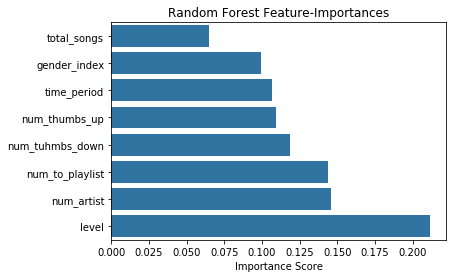

In [94]:
features_importances = rf_bestModel.featureImportances.values
features_importances = np.sort(features_importances)

sns.barplot( x = features_importances, y = feature_col, color = sns.color_palette()[0])
plt.xlabel('Importance Score')
plt.title('Random Forest Feature-Importances')

* 从图中可以看出**level**特征对于模型表现来说影响最大，**total_songs**相对来说重要性一般

## 6 总结
**在本次项目中，我们尝试建立一个模型来预测一个应用的客户流失情况**
* 在数据加载清洗中，我们首先在本地操作系统中将数据压缩成了bz2格式，然后对数据集进行加载，去除了可能存在空值的数据，去除了含有空字符串的用户
* 在探索性数据化分析中，我们首先定义了客户流失的行为特征，并将其通过（1，0）值对每个用户进行标记，并将时间相关特征转换成方便人阅读的格式
* 可视化分析中，我们探索了不同变量于用户流失之间的关系，我们发现：
    1. *男用户流失比女用户略多一点*
    2. *曾付费的用户反而比免费使用的用户流失的多，说明应用所提供的服务可能很不好*
    3. *点赞与差评之间的比值与用户流失与否有着一定的关系，比值越高的用户相对来说不容易流失*
    4. *流失的用户相对于没有流失的用户总体使用应用服务的时间要少一些*
* 我们对数据进行特征工程，包括特征筛选创建，聚合特征与标签，其中我们将level，gender特征转换为了int格式，方便模型训练，最后我们得出了7个特征一个目标标签的数据集；接着我们对特征进行向量化，并使用Nomalizer对特征进行归一化，得到最终数据集
* 我们将最终数据集拆分成训练集，验证集和测试集，并选取4个机器学习模型，对训练集进行训练
* 训练出的模型，通过验证集的预测，综合比较我们选择了**Random Forest**作为最佳的模型，并让该模型对测试集进行预测，并评价结果
* 最后观察结果发现**F-1 Score**比验证集预测有着较大的下滑，模型可能存在过拟合的问题，可以通过后续在本地环境中调参，尝试寻找更优的模型
* 对模型进行调参后发现当参数**numTrees=20,maxDepth=10**时模型表现最好，选择该参数重新训练模型并对测试集进行预测
* 最后得出结果：
    Best Model Metrics:

    Accuracy: 0.7352941176470589

    F-1 Score: 0.7036625971143174
* 再对模型进行特征重要性探索，发现**level**特征对于模型表现来说影响最大，**total_songs**相对来说重要性一般